<a id = 'toc'></a>
# Table of Contents

- ### [Trend, Seasonality, Noise](#trend_seasonality_noise)
- ### [Factors](#factors)
    - [Window Functions](#window_functions)
    - [Moving Average](#moving_average)
    - [Lags](#lags)

<a id = 'trend_seasonality_noise'></a>
# Trend, Seasonality, Noise

"Seasonal decompose" helps us to decompose the time series into trend and seasonality. 



In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Upload/15.5.AirPassengers.csv')
df.columns = ['month', 'passengers']
df.head()

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df = df.set_index(pd.DatetimeIndex(df['month']))
df.head()

,month,passengers
month,,
1949-01-01,1949-01,112
1949-02-01,1949-02,118
1949-03-01,1949-03,132
1949-04-01,1949-04,129
1949-05-01,1949-05,121


In [5]:
df.drop(columns = ['month'], axis = 0, inplace = True)

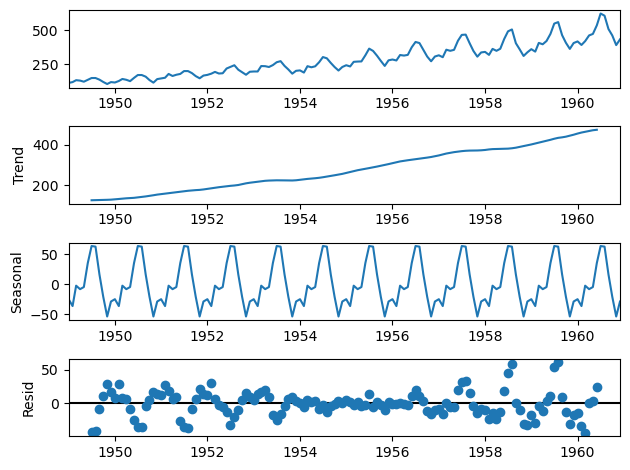

In [6]:
decomposition = seasonal_decompose(df, model = 'addative')
decomposition.plot()
plt.show()

In [7]:
trend_part = decomposition.trend
seasonal_part = decomposition.seasonal
residual_part = decomposition.resid

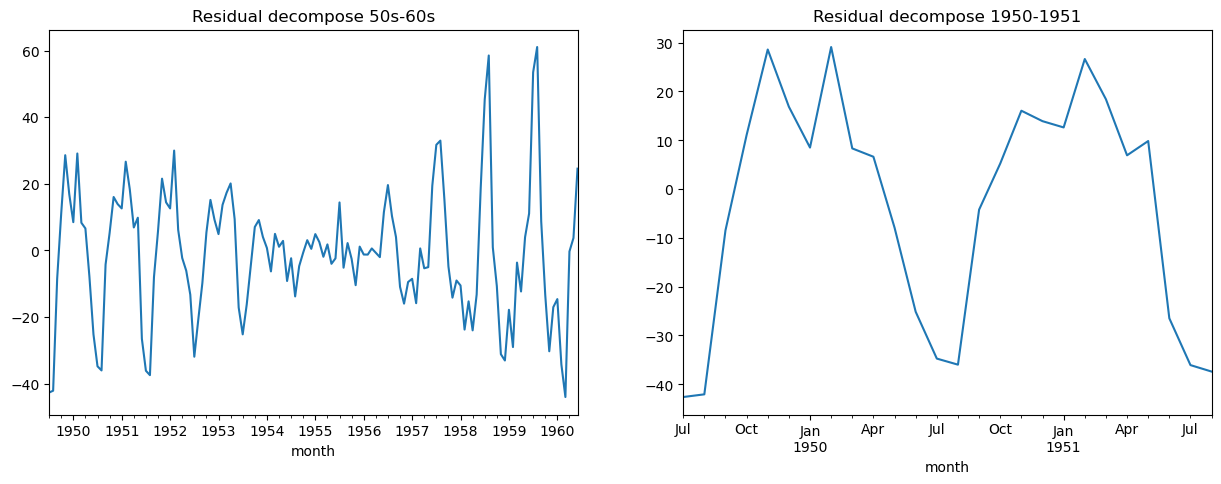

In [8]:
residual_part = residual_part.dropna()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (15, 5))
residual_part.plot(ax = ax1)
residual_part['1949-07-01':'1951-08-01'].plot(ax = ax2)
ax1.set_title('Residual decompose 50s-60s')
ax2.set_title('Residual decompose 1950-1951')
plt.show()

<a id = 'factors'></a>
# Factors

<a id = 'window_functions'></a>
## Window Functions in Pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('Upload/15.8.csv')
df['ts'] = pd.to_datetime(df.ts)
df = df.iloc[1000:1100]
df.reset_index(drop = True, inplace = True)
df.head()

,ts,open,high,low,close,vol
0,2018-01-02 18:42:00,1314.3,1314.4,1313.9,1313.9,323
1,2018-01-02 18:43:00,1314.0,1314.2,1314.0,1314.0,177
2,2018-01-02 18:44:00,1314.0,1314.0,1313.7,1313.9,216
3,2018-01-02 18:45:00,1313.9,1314.1,1313.8,1314.0,170
4,2018-01-02 18:46:00,1314.0,1314.1,1314.0,1314.0,186


In [3]:
def myMax(value):
    return max(value)

df['rolling_mean'] = df.close.rolling(window = 5).mean()
df['rolling_std'] = df.close.rolling(window = 5).std()
df['rolling_max'] = df.close.rolling(window = 5).apply(myMax, raw = False)

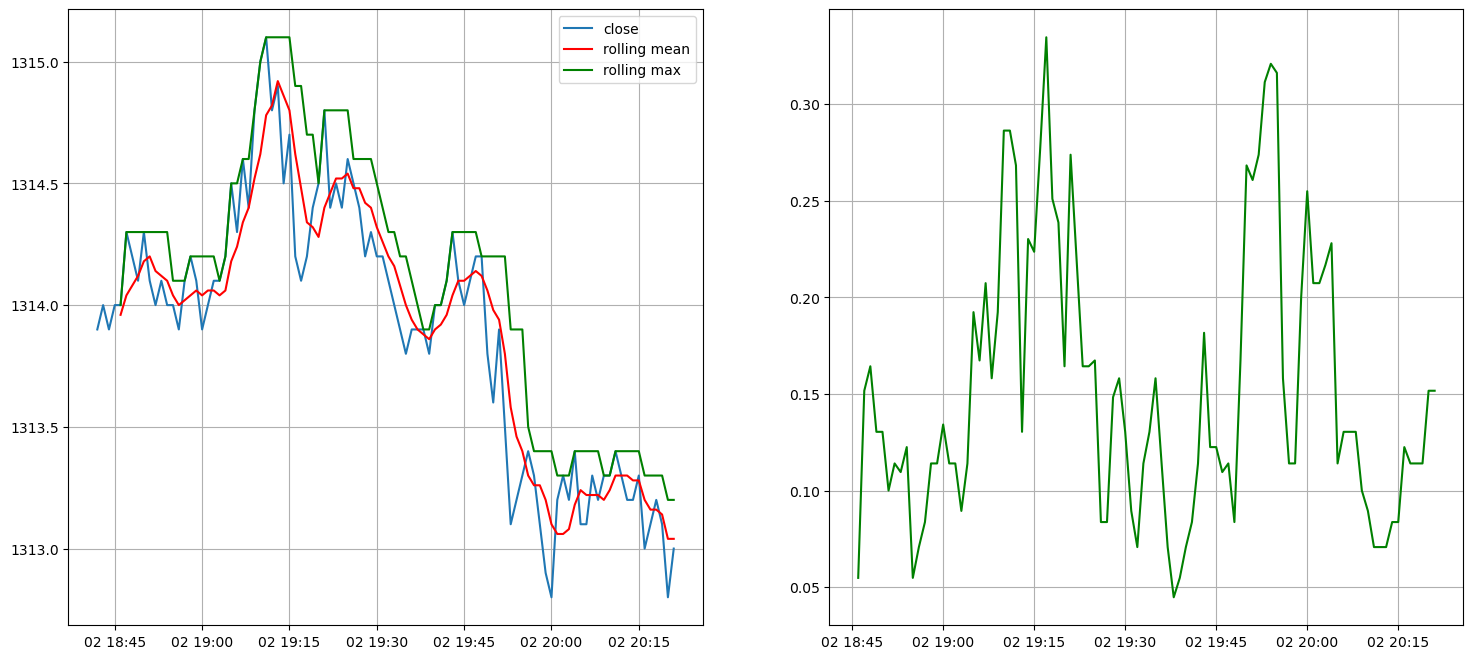

,ts,open,high,low,close,vol,rolling_mean,rolling_std,rolling_max
0,2018-01-02 18:42:00,1314.3,1314.4,1313.9,1313.9,323,NaN,NaN,NaN
1,2018-01-02 18:43:00,1314.0,1314.2,1314.0,1314.0,177,NaN,NaN,NaN
2,2018-01-02 18:44:00,1314.0,1314.0,1313.7,1313.9,216,NaN,NaN,NaN
3,2018-01-02 18:45:00,1313.9,1314.1,1313.8,1314.0,170,NaN,NaN,NaN
4,2018-01-02 18:46:00,1314.0,1314.1,1314.0,1314.0,186,1313.96,0.054772,1314.0
5,2018-01-02 18:47:00,1314.0,1314.3,1314.0,1314.3,99,1314.04,0.151658,1314.3
6,2018-01-02 18:48:00,1314.3,1314.4,1314.2,1314.2,99,1314.08,0.164317,1314.3
7,2018-01-02 18:49:00,1314.2,1314.2,1314.1,1314.1,113,1314.12,0.130384,1314.3
8,2018-01-02 18:50:00,1314.2,1314.3,1314.1,1314.3,129,1314.18,0.130384,1314.3
9,2018-01-02 18:51:00,1314.4,1314.4,1314.1,1314.1,139,1314.20,0.100000,1314.3


In [4]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].plot(df.ts, df.close)
ax[0].plot(df.ts, df.rolling_mean, c='r')
ax[0].plot(df.ts, df.rolling_max,  c='g')
ax[0].legend(['close', 'rolling mean', 'rolling max'])
ax[0].grid()

ax[1].plot(df.ts, df.rolling_std, c='g') ## оконное стандартное отклонение
ax[1].grid()
plt.show()

df.head(12)

<a id = 'moving_average'></a>
## Moving Average

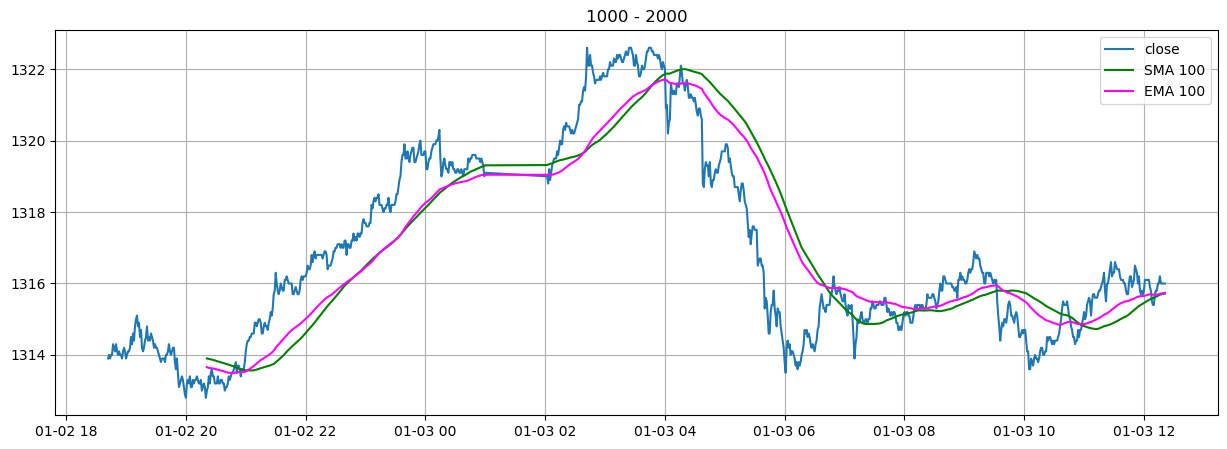

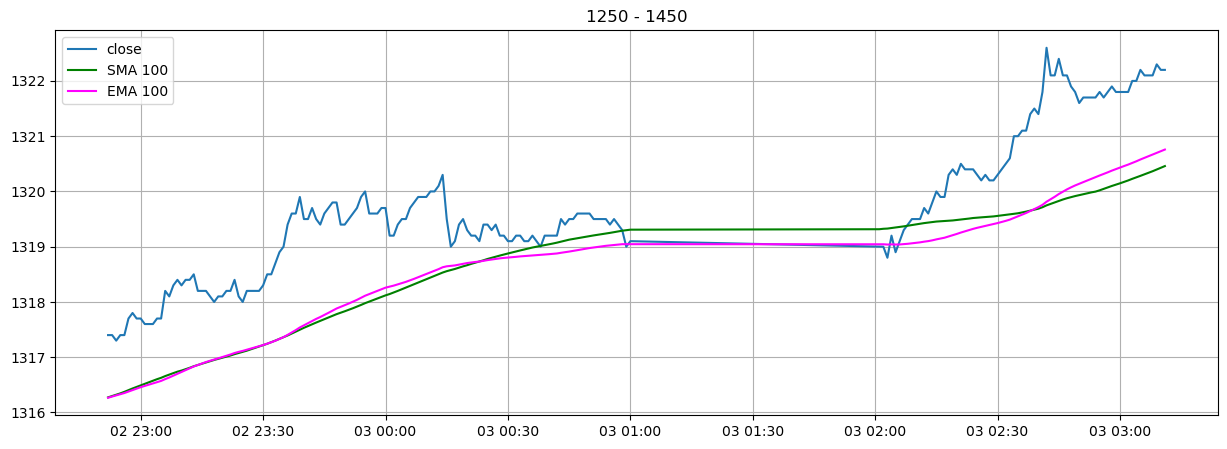

In [57]:
df = pd.read_csv('Upload/15.8.csv')
df['ts'] = pd.to_datetime(df.ts)
df = df.iloc[1000:2000]

df['rolling_mean_100'] = df.close.rolling(window = 100).mean()
df['rolling_ema_100'] = df.close.ewm(min_periods = 100, span = 100).mean()

fig, axes = plt.subplots(1, 1, figsize = (15,5))

axes.plot(df.ts, df['close'])
axes.plot(df.ts, df['rolling_mean_100'], c = 'g')
axes.plot(df.ts, df['rolling_ema_100'], c = 'magenta')
axes.legend(['close', 'SMA 100', 'EMA 100'])
axes.set_title('1000 - 2000')
axes.grid()

fig, axes = plt.subplots(1, 1, figsize = (15,5))

axes.plot(df.ts[250:450], df['close'][250:450])
axes.plot(df.ts[250:450], df['rolling_mean_100'][250:450], c = 'g')
axes.plot(df.ts[250:450], df['rolling_ema_100'][250:450], c = 'magenta')
axes.legend(['close', 'SMA 100', 'EMA 100'])
axes.set_title('1250 - 1450')
axes.grid()

plt.show()

<a id = 'lags'></a>
## Lags

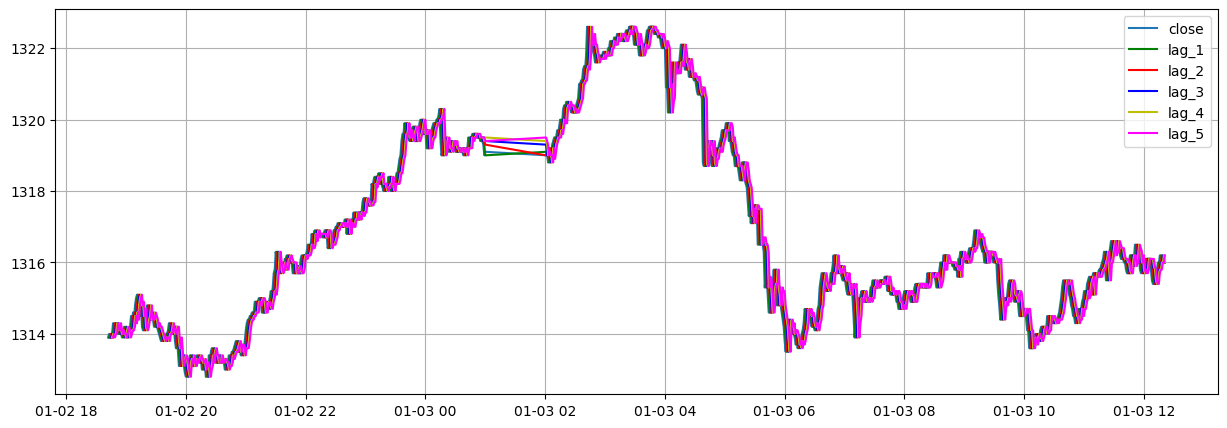

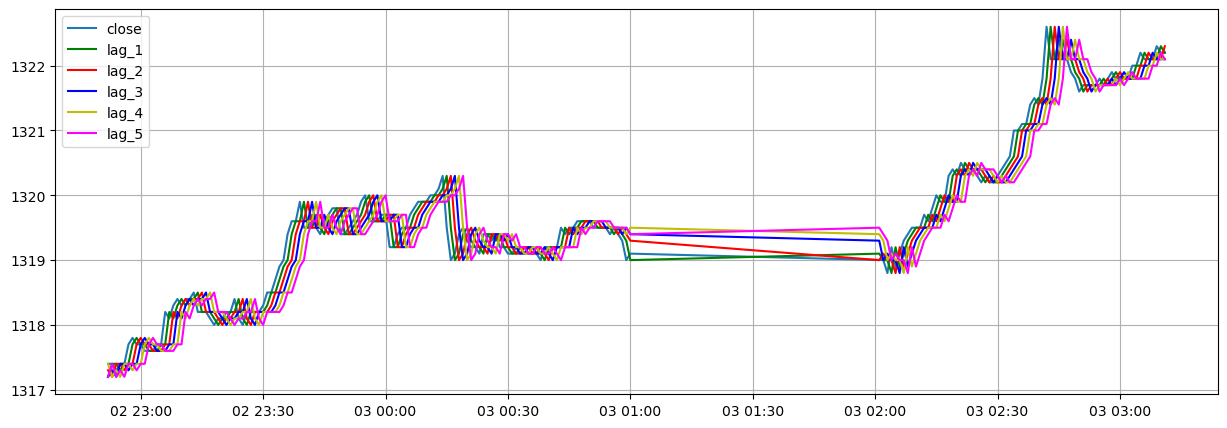

In [63]:
for i in range(1,6):
    df['lag_{}'.format(i)] = df.close.shift(i)


f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df.ts, df.close)
ax.plot(df.ts, df['lag_' + str(1)],  c='g') 
ax.plot(df.ts, df['lag_' + str(2)],  c='r') 
ax.plot(df.ts, df['lag_' + str(3)],  c='b') 
ax.plot(df.ts, df['lag_' + str(4)],  c='y') 
ax.plot(df.ts, df['lag_' + str(5)],  c='magenta') 
ax.legend(['close', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'])
ax.grid()

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df.ts[250:450], df.close[250:450])
ax.plot(df.ts[250:450], df['lag_' + str(1)][250:450],  c='g') 
ax.plot(df.ts[250:450], df['lag_' + str(2)][250:450],  c='r') 
ax.plot(df.ts[250:450], df['lag_' + str(3)][250:450],  c='b') 
ax.plot(df.ts[250:450], df['lag_' + str(4)][250:450],  c='y') 
ax.plot(df.ts[250:450], df['lag_' + str(5)][250:450],  c='magenta') 
ax.legend(['close', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'])
ax.grid()

---
## Decoding
converting a sequence of bytes into a sequence of characters.

- **Unpacking** \
*.plain/.zip/.gz/...*
- **Encoding** \
*ASCII/utf-8/Windows-1251/...*
- **Format** \
*csv/xml/json/doc/...*

---

## Split into tokens
splitting a sequence of characters into parts (tokens), possibly excluding some characters from consideration.
Naive approach: split the string with spaces and throw out punctuation marks.

**Problems:**  
* example@example.com, 127.0.0.1
* С++, C#
* York University vs New York University
* Language dependency (“Lebensversicherungsgesellschaftsangestellter”, “l’amour”)

Alternative: n-grams

---

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer

sequence = 'The quick brown fox jumps, and jumps over the lazy dog'

tokenizer = RegexpTokenizer('\w+|[^\w\s]+')
for token in tokenizer.tokenize(sequence):
    print(token)

The
quick
brown
fox
jumps
,
and
jumps
over
the
lazy
dog


---
## Stop words
the most frequent words in the language that do not contain any information about the content of the text

**Problem**: To be or not to be.

---

In [3]:
from nltk.corpus import stopwords

print(' '.join(stopwords.words('english')[1:20]))

me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his


---
## Normalization
Bringing tokens to a single form in order to get rid of superficial differences in spelling

**Approaches:**
* formulate a set of rules by which the token is transformed \
New-Yorker → new-yorker → newyorker → newyork
* explicity store connections betweens tokens (WordNet - Princeton) \
car → auto, Window 6 → window
машина → автомобиль, Windows 6→ window

---

In [4]:
word = 'New-Yorker'

word_1 = word.lower()

import re
word_2 = re.sub(r'\W', '', word_1, flags = re.U)

word_3 = re.sub(r'er', '', word_2, flags = re.U)

print(f'{word} → {word_1} → {word_2} → {word_3}')

New-Yorker → new-yorker → newyorker → newyork


---
## Stemming and Lemmatization
**Stemming** is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
**Lemmatization** considers the conext and converts the word to its meaningful base form, which is called *Lemma*.

**Example:**
* Steeming
Caring → Car
* Lemmatization
Caring → Care

---

## Stemming

In [5]:
from nltk.stem.snowball import PorterStemmer
from nltk.stem.snowball import EnglishStemmer

p_stemmer = PorterStemmer()
print(f'[Porter Stemmer]: {p_stemmer.stem("New-Yorker")}')
print(f'[Porter Stemmer]: {p_stemmer.stem("Tokenization")}')

eng_stemmer = EnglishStemmer()
print(f'[English Stemmer]: {eng_stemmer.stem("Perfection")}')
print(f'[English Stemmer]: {eng_stemmer.stem("Difference")}')

[Porter Stemmer]: new-york
[Porter Stemmer]: token
[English Stemmer]: perfect
[English Stemmer]: differ


## Lemmatization

In [6]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
print(f'[pymorphy2]: {morph.parse("New-Yorker")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Tokenization")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Perfection")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Difference")[0].normal_form}')

[pymorphy2]: new-yorker
[pymorphy2]: tokenization
[pymorphy2]: perfection
[pymorphy2]: difference


---

## Heap's Law (Herdan's law)
An empirical regularity in linguistics that describes the distribution of the number of unique words in a document (or set of documents) as a function of it's length.


$ M = kT^{\beta}$
- $M$ - dictionary size
- $T$ - word count
- $30 \leq k \leq 100, b \approx 0.5$

---

[UP](#toc)

<a id = 'preprocessing_pandas'></a>
# Preprocessing-Pandas

#### Using methods

In [8]:
import pandas as pd

sequences_list = pd.Series(['Our mother washed - The Dishes', 'The countdown, Is over'], dtype = "string")
print(f'[BEFORE]: {sequences_list[0]}')

sequences_list = sequences_list.str.lower()
sequences_list = sequences_list.str.strip()
#sequences_list = sequences_list.str.split(' ', expand = True)
sequences_list = sequences_list.str.split(' ')
print(f'[AFTER]: {sequences_list[0]}')

[BEFORE]: Our mother washed - The Dishes
[AFTER]: ['our', 'mother', 'washed', '-', 'the', 'dishes']


#### Using functions

In [9]:
import string
import pymorphy2

morpher = pymorphy2.MorphAnalyzer()
sw = ['dishes']

def preprocess_txt(line):
    exclude = set(string.punctuation)
    spls = ''.join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != '']
    return spls
    
sequences_list = pd.Series(['Our mother washed - The Dishes', 'The countdown, Is over'], dtype = "string")
print(f'[BEFORE]: {sequences_list[0]}')
sequences_list = sequences_list.apply(lambda x: preprocess_txt(x))
print(f'[AFTER]: {sequences_list[0]}')

[BEFORE]: Our mother washed - The Dishes
[AFTER]: ['our', 'mother', 'washed', 'the']


[UP](#toc)

<a id = 'word_vectorization'></a>
# Word vectorization

### Bag-of-Words

In [13]:
documents = ["I like this movie, it's funny.", "I hate this movie."
             , "This was awesome! I like it.", "Nice one. I love it."]

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(documents)

count_vectorizer.fit_transform(documents)

feature_names = count_vectorizer.get_feature_names_out()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

,awesome,funny,hate,it,like,love,movie,nice,one,this,was
0,0,1,0,1,1,0,1,0,0,1,0
1,0,0,1,0,0,0,1,0,0,1,0
2,1,0,0,1,1,0,0,0,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0


### N-gramm

In [14]:
from nltk.util import ngrams

text = "I like this movie, it's funny. I hate this movie. This was awesome! I like it. Nice one. I love it."

tokenized = text.split()
bigrams = ngrams(tokenized, 2)
for i in bigrams:
    print(i)

('I', 'like')
('like', 'this')
('this', 'movie,')
('movie,', "it's")
("it's", 'funny.')
('funny.', 'I')
('I', 'hate')
('hate', 'this')
('this', 'movie.')
('movie.', 'This')
('This', 'was')
('was', 'awesome!')
('awesome!', 'I')
('I', 'like')
('like', 'it.')
('it.', 'Nice')
('Nice', 'one.')
('one.', 'I')
('I', 'love')
('love', 'it.')


### TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

document = ["I like this movie, it's funny.", "I hate this movie."
            , "This was awesome! I like it.", "Nice one. I love it."]
tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(document)

feature_name = tfidf_vectorizer.get_feature_names_out()
pd.DataFrame(values.toarray(), columns = feature_names)

,awesome,funny,hate,it,like,love,movie,nice,one,this,was
0,0.000000,0.571848,0.000000,0.365003,0.450852,0.000000,0.450852,0.000000,0.000000,0.365003,0.000000
1,0.000000,0.000000,0.702035,0.000000,0.000000,0.000000,0.553492,0.000000,0.000000,0.448100,0.000000
2,0.539445,0.000000,0.000000,0.344321,0.425305,0.000000,0.000000,0.000000,0.000000,0.344321,0.539445
3,0.000000,0.000000,0.000000,0.345783,0.000000,0.541736,0.000000,0.541736,0.541736,0.000000,0.000000


### Hashing

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

document = ["I like this movie, it's funny.", "I hate this movie."
            , "This was awesome! I like it.", "Nice one. I love it."]

vectorizer = HashingVectorizer()
values = vectorizer.fit_transform(document)

pd.DataFrame(values.toarray())

,0,1,2,3,4,5,6,7,8,9,...,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574,1048575
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[UP](#toc)

<a id = 'example_1'></a>
# Example 1

In [2]:
import numpy as np
import matplotlib.pyplot
%matplotlib inline

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [3]:
dataset = datasets.load_dataset('imdb'
                                , split = 'train'
                                , download_mode = 'force_redownload')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
df = dataset
df = datasets.load_dataset('imdb')

In [5]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

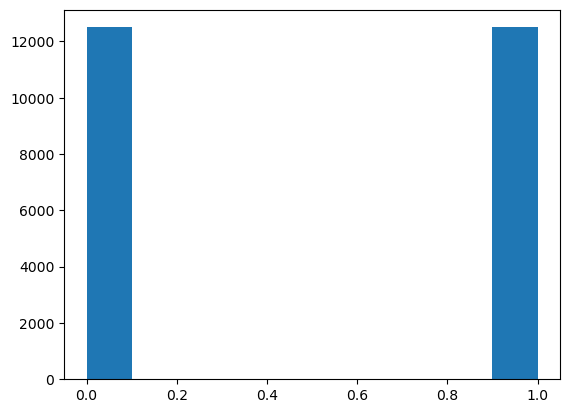

In [6]:
import matplotlib.pyplot as plt

train_labels = [i['label'] for i in df['train']]
plt.hist(train_labels)
plt.show()

### Classification using Linear Models

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer(max_features = 25000)
values = vectorizer.fit_transform(df['train']['text'])

feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(values.toarray(), columns = feature_names)

,00,000,007,00s,01,02,03,04,05,06,...,zooming,zooms,zorak,zorro,zp,zu,zucker,zulu,zuniga,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
vectorizer = TfidfVectorizer(max_features = 25000)
vectorizer = vectorizer.fit(df['train']['text'])

x_train = vectorizer.transform(df['train']['text'])
y_train = np.array(df['train']['label'])

x_test = vectorizer.transform(df['test']['text'])
y_test = np.array(df['test']['label'])

x_train, y_train

(<25000x25000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3355130 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 1, 1, 1]))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

model = LogisticRegression()
model = model.fit(x_train, y_train)

log_pred = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, log_pred))
acc = accuracy_score(y_test, log_pred)

print(f'[RMSE]: {rmse:.2f}, [ACC]: {acc:.2f}')

[RMSE]: 0.34, [ACC]: 0.88


#### Testing model prediction

In [10]:
positive_comment = 'This movie is awesome!'
vec = vectorizer.transform([positive_comment])
positive_pred = model.predict(vec)

negative_comment = 'This movie is awful!'
vec = vectorizer.transform([negative_comment])
negative_pred = model.predict(vec)

print(f'[PositiveComment]: {positive_pred[0]}, \
[NegativeComment]: {negative_pred[0]}')

[PositiveComment]: 1, [NegativeComment]: 0


[UP](#toc)

<a id = 'gensim'></a>
# Gensim

In [4]:
import gensim.downloader as api

word_vectors = api.load('glove-wiki-gigaword-100')

result = word_vectors.most_similar(positive = ['woman', 'king'], negative = ['man'])
print(word_vectors.doesnt_match('breakfast dinner cereal lunch'.split()))

similarity = word_vectors.similarity('woman', 'man')
print(f'{similarity:.2f}')

<a id = 'text_classification'></a>
# Text Classification

- Naive Bayes
- SVM
- LogisticRegression
- RandomForestClassifier
- XGBoostClassifier

In [87]:
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
#from sklearn import naive_bayes, linear_model, ensemble, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm_notebook
%pylab inline

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [88]:
df = pd.read_excel('Upload/14.7.xls')

In [89]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [91]:
exclude = set(punctuation)
sw = set(get_stop_words('ru'))
morpher = MorphAnalyzer()

In [92]:
df_sample = df.iloc[:5000]

In [93]:
def preprocess_text(line):
    splt = str(line)
    splt = ''.join(i for i in splt if i not in exclude)
    splt = splt.lower()
    splt = re.sub('не\s', 'не', splt)
    splt = [morpher.parse(word)[0].normal_form for word in splt.split() if word not in exclude]
    return ' '.join(splt)

#df_sample['Content'].apply(lambda x: preprocess_text(x))

In [94]:
df_sample['text'] = df_sample['Content'].apply(preprocess_text)
df_sample_rating = df_sample[df_sample['Rating'] != 3]
df_sample_rating['target'] = df_sample_rating['Rating'] > 3

C:\Users\Leo\AppData\Local\Temp\ipykernel_15996\725875120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['text'] = df_sample['Content'].apply(preprocess_text)
C:\Users\Leo\AppData\Local\Temp\ipykernel_15996\725875120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_rating['target'] = df_sample_rating['Rating'] > 3


In [95]:
x_train, x_test, train_y, test_y = train_test_split(df_sample_rating['text']
                                                                    , df_sample_rating['target'])

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_y)
y_test = encoder.fit_transform(test_y)

In [96]:
x_train.shape, x_test.shape

((3585,), (1195,))

In [115]:
count_vectorizer = CountVectorizer().fit(x_train.values)
x_train_count = count_vectorizer.transform(x_train)
x_test_count = count_vectorizer.transform(x_test)

tfidf_vectorizer = TfidfVectorizer().fit(x_train.values)
x_train_tfidf = tfidf_vectorizer.transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range = (1, 3)).fit(x_train.values)
x_train_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_train)
x_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_test)

In [117]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net = False):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis = -1)
        
    return accuracy_score(predictions, y_test)

## Naive Bayes

In [119]:
acc_nb_count = train_model(naive_bayes.MultinomialNB(), x_train_count, y_train, x_test_count)
acc_nb_tfidf = train_model(naive_bayes.MultinomialNB(), x_train_tfidf, y_train, x_test_tfidf)
acc_nb_tfidf_ngram = train_model(naive_bayes.MultinomialNB(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_nb_count:.2f}, [TF-IDF]: {acc_nb_tfidf:.2f}, [TF-IDF N-Gram]: {acc_nb_tfidf_ngram:.2f}')

[Count]: 0.93, [TF-IDF]: 0.89, [TF-IDF N-Gram]: 0.87


## Linear Classifier - Logistic Regression

In [121]:
acclrcount = train_model(LogisticRegression(), x_train_count, y_train, x_test_count)
acclrtfidf = train_model(LogisticRegression(), x_train_tfidf, y_train, x_test_tfidf)
acclrtfidf_ngram = train_model(LogisticRegression(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acclrcount:.2f}, [TF-IDF]: {acclrtfidf:.2f}, [TF-IDF N-Gram]: {acclrtfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


## SVM

In [122]:
acc_svm_count = train_model(svm.SVC(), x_train_count, y_train, x_test_count)
acc_svm_tfidf = train_model(svm.SVC(), x_train_tfidf, y_train, x_test_tfidf)
acc_svm_tfidf_ngram = train_model(svm.SVC(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_svm_count:.2f}, [TF-IDF]: {acc_svm_tfidf:.2f}, [TF-IDF N-Gram]: {acc_svm_tfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.91, [TF-IDF N-Gram]: 0.90


## Random Forest

In [124]:
clf = ensemble.RandomForestClassifier(n_estimators = 10000).fit(x_train_count, y_train)

In [125]:
acc_scores = []

for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):
    clf =  ensemble.RandomForestClassifier(n_estimators = i).fit(x_train_count, y_train)
    acc_scores.append(accuracy_score(clf.predict(x_test_count), y_test))
    
acc_rfc_count = np.mean(acc_scores)

C:\Users\Leo\AppData\Local\Temp\ipykernel_12192\4151042975.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):


  0%|          | 0/6 [00:00<?, ?it/s]

In [126]:
acc_rfc_tfidf = train_model(ensemble.RandomForestClassifier(), x_train_tfidf, y_train, x_test_tfidf)
acc_rfc_tfidf_ngram = train_model(ensemble.RandomForestClassifier(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_rfc_count:.2f}, [TF-IDF]: {acc_rfc_tfidf:.2f}, [TF-IDF N-Gram]: {acc_rfc_tfidf_ngram:.2f}')

[Count]: 0.90, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


## Boosting Model

In [128]:
acc_xgb_count = train_model(XGBClassifier(), x_train_count, y_train, x_test_count)
acc_xgb_tfidf = train_model(XGBClassifier(), x_train_tfidf, y_train, x_test_tfidf)
acc_xgb_tfidf_ngram = train_model(XGBClassifier(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_xgb_count:.2f}, [TF-IDF]: {acc_xgb_tfidf:.2f}, [TF-IDF N-Gram]: {acc_xgb_tfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


<a id = 'example_2'></a>
# Example 2: ChatBotPractice

In [2]:
import string
import os 
import annoy
import codecs

from stop_words import get_stop_words
from gensim.models import Word2Vec
from pymorphy2 import MorphAnalyzer

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
start = 0
end = 10000

question = None
written = False

with codecs.open('Upload/prepared_answers.txt','w', 'utf-8') as fout:
    with codecs.open('Upload/14.8.txt', 'r', 'utf-8') as fin:
        for line in tqdm(fin):
            if line.startswith('---'):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace('\t', ' ').strip() + '\t' + line.replace('\t', ' '))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue
            start += 1
            if start > end:
                break

0it [00:00, ?it/s]

### Count Vectorizer, Hashing Vectorizer, TF-IDF Vectorizer

In [4]:
# sentences_vec = pd.Series([' '.join(i) for i in [k for k in sentences if len(k) > 2]])

# from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer()
# x_train = count_vectorizer.fit_transform(sentences_vec)
# feature_names = count_vectorizer.get_feature_names_out()
# df_count_vectorizer = pd.DataFrame(x_train.toarray(), columns = feature_names)

# from sklearn.feature_extraction.text import HashingVectorizer

# hashing_vectorizer = HashingVectorizer()
# x_train = hashing_vectorizer.fit_transform(sentences_vec)
# df_hashing_vectorizer = pd.DataFrame(x_train.toarray())

# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer()
# x_train = tfidf_vectorizer.fit_transform(sentences_vec)
# feature_names = tfidf_vectorizer.get_feature_names_out()
# df_tfidf_vectorizer = pd.DataFrame(x_train.toarray(), columns = feature_names)

# print(f'[COUNT]: {df_count_vectorizer.shape}')
# print(f'[HASHING]: {df_hashing_vectorizer.shape}')
# print(f'[TF-IDF]: {df_tfidf_vectorizer.shape}')

In [11]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

sentences = []

morpher = MorphAnalyzer()
sw = set(get_stop_words('ru'))
exclude = set(string.punctuation)
c = 0

with codecs.open('Upload/14.8.txt', 'r', 'utf-8') as fin:
    for line in tqdm(fin):
        spls = preprocess_txt(line)
        sentences.append(spls)
        c += 1
        if c > 5000:
            break

0it [00:00, ?it/s]

### Word2Vec

In [13]:
from gensim.models import Word2Vec

sentences = [i for i in sentences if len(i) > 2]
model = Word2Vec(sentences = sentences, vector_size = 100, min_count = 1, window = 5)
model.save('Assets/word2vec_model')

### Annoy

In [15]:
import annoy 

index = annoy.AnnoyIndex(100 ,'angular')

index_map = {}
counter = 0

with codecs.open('Upload/prepared_answers.txt', 'r', 'utf-8') as f:
    for line in tqdm(f):
        n_w2v = 0
        spls = line.split("\t")
        index_map[counter] = spls[1]
        question = preprocess_txt(spls[0])
        vector = np.zeros(100)
        for word in question:
            if word in model.wv:
                vector += model.wv[word]
                n_w2v += 1
        if n_w2v > 0:
            vector = vector / n_w2v
        index.add_item(counter, vector)
        counter += 1
        if counter > 1000:
            break
        
index.build(10)
index.save('Assets/speaker.ann')

0it [00:00, ?it/s]

True

In [16]:
def find_answer(question):
    preprocessed_question = preprocess_txt(question)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_question:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index.get_nns_by_vector(vector, 1)
    return index_map[answer_index[0]]

In [18]:
find_answer('Как стать принцессой?')

'думаю, что греха никакого нет. мы в проекте, независимо от возраста, равные. и порой по вопросу чувствуешь, что отвечаешь очень юному человеку. в таком случае подсознательно обращаешься на ты. но оскорбленных пока не было. спасибо тем, кто отвечает с благодарностью за подсказку.. \n'